# Plane CV 

The goal here is to try to establish flying speed from camera images. 

The grand idea is to: 
- identify plane
- determine its specs (wingspan etc) 
- measure the increase in wingspan over time
- calculate and display speed on the video

![early notes](img/planeCV.jpg)


# Unity simulation
- plane models 
- jitter images to create a large data set 
- train a deep model to recognize planes 
- randomly generate planes to come down the runway
- random speeds within a plausible range 
- in game camera detects plane
- then identifies it and begins to calculate the speed based on pixels 
- then tracks it (using skillz from udacity) 

# Processing each image

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import cv2
# import glob
# from skimage.feature import hog
# from skimage import color, exposure
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
import time
import scipy
import collections

In [15]:
# getting a couple of frames from a subclip for some analysis
# clip1 = VideoFileClip("baron_beacon_approach.mp4")

# making a smaller subclip for time sake
# test_clip = clip1.subclip(10,15)

# test_clip.save_frame("frame1.png") # saves the first frame
# test_clip.save_frame("frame2.png", t=5) # saves the frame a t=2s

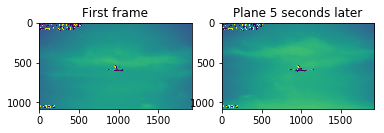

In [16]:
# plotting the two images 
# Plot the examples
frame1 = cv2.imread("frame1.png",0)
frame2 = cv2.imread("frame2.png",0)

fig = plt.figure()
plt.subplot(121)
plt.imshow(frame1)
plt.title('First frame')
plt.subplot(122)
plt.imshow(frame2)
plt.title('Plane 5 seconds later')
plt.savefig('Plane_5_seconds.png',transparent=True)

In [17]:
frame1.shape

(1080, 1920)

In [18]:
frame1

array([[ 68,  68,  70, ...,  68,  68,  68],
       [ 68,  68,  68, ...,  70,  68,  68],
       [ 68,  68,  67, ...,  70,  68,  68],
       ..., 
       [ 92,  92,  93, ..., 109, 108, 108],
       [ 92,  93,  93, ..., 109, 110, 110],
       [ 92,  94,  94, ..., 110, 111, 111]], dtype=uint8)

In [6]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [3]:
# so what I am starting with is simply a measurement from one frame to the next
# divided by delta t to get a sort of velocity measurement

# 1. convert to gray
# 2. gaussian blur
# 3. sobel gradients and binary image
# 4. canny
# 5. findCountours



# gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(frame1,(7,7),0)

# edges = cv2.Canny(frame1, 50, 100)

sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 3)

abs_sobel_x = np.absolute(sobel_x)
abs_sobel_y = np.absolute(sobel_y)

scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))


thresh = (10,255)
sx_binary = np.zeros_like(scaled_sobel_x)
sx_binary[(scaled_sobel_x >= thresh[0]) & (scaled_sobel_x <= thresh[1])] = 1  

sy_binary = np.zeros_like(scaled_sobel_y)
sy_binary[(scaled_sobel_y >= thresh[0]) & (scaled_sobel_y <= thresh[1])] = 1

# Combine the two binary thresholds
combined_binary = np.zeros_like(sx_binary)
combined_binary[(sx_binary == 1) | (sx_binary == 1)] = 1


vertices = np.array([[(0,200),(1920, 200), (1920,1000), (0,1000)]], dtype=np.int32) # also this works without "dtype"
roi = region_of_interest(combined_binary, vertices)

roi = cv2.dilate(roi, None, iterations=10)
roi = cv2.erode(roi, None, iterations=10)

blob = roi # saving out the dialated and erode image for visualization

ret,thresh = cv2.threshold(roi,0,255,0)
im2,contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
max_w = 0
for c in contours:

    # # getting the bounding box
    x,y,w,h = cv2.boundingRect(c)
    roi = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
    if w > max_w:
        max_w = w


NameError: name 'cv2' is not defined

In [8]:
plt.imshow(warped, cmap="gray")

NameError: name 'warped' is not defined

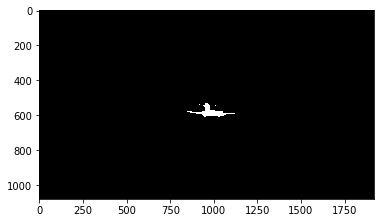

In [9]:
plt.imshow(roi, cmap="gray")

In [11]:
roi = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY)[1]
roi = cv2.cvtColor(roi,cv2.COLOR_GRAY2RGB)
cv2.imwrite("roi.jpg", roi)

True

In [45]:
# this function is from the feature matching assignment

def drawMatches(image_1, image_1_keypoints, image_2, image_2_keypoints, matches):
    
    """ Draws the matches between the image_1 and image_2.

    Note: Do not edit this function, it is provided for you for visualization
    purposes.

    Args:
    image_1 (numpy.ndarray): The first image (can be color or grayscale).
    image_1_keypoints (list): The image_1 keypoints, the elements are of type
                              cv2.KeyPoint.
    image_2 (numpy.ndarray): The image to search in (can be color or grayscale)
    image_2_keypoints (list): The image_2 keypoints, the elements are of type
                              cv2.KeyPoint.

    Returns:
    output (numpy.ndarray): An output image that draws lines from the input
                            image to the output image based on where the
                            matching features are.
    """
    # Compute number of channels.
    num_channels = 1
    if len(image_1.shape) == 3:
        num_channels = image_1.shape[2]
    # Separation between images.
    margin = 10
    # Create an array that will fit both images (with a margin of 10 to
    # separate the two images)
    joined_image = np.zeros((max(image_1.shape[0], image_2.shape[0]),
                            image_1.shape[1] + image_2.shape[1] + margin,
                            3))
    if num_channels == 1:
        for channel_idx in range(3):
            joined_image[:image_1.shape[0],
                         :image_1.shape[1],
                         channel_idx] = image_1
            joined_image[:image_2.shape[0],
                         image_1.shape[1] + margin:,
                         channel_idx] = image_2
    else:
        joined_image[:image_1.shape[0], :image_1.shape[1]] = image_1
        joined_image[:image_2.shape[0], image_1.shape[1] + margin:] = image_2

    for match in matches:
        image_1_point = (int(image_1_keypoints[match.queryIdx].pt[0]),
                         int(image_1_keypoints[match.queryIdx].pt[1]))
        image_2_point = (int(image_2_keypoints[match.trainIdx].pt[0] +
                             image_1.shape[1] + margin),
                         int(image_2_keypoints[match.trainIdx].pt[1]))

        rgb = (np.random.rand(3) * 255).astype(np.int)
        cv2.circle(joined_image, image_1_point, 5, rgb, thickness=-1)
        cv2.circle(joined_image, image_2_point, 5, rgb, thickness=-1)
        cv2.line(joined_image, image_1_point, image_2_point, rgb, thickness=3)

    return joined_image

# feature detection , homography, pose estimation

True

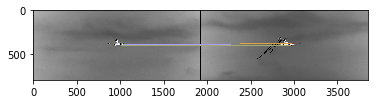

In [52]:
frame1 = cv2.imread("frame1.png",0)
frame2 = cv2.imread("frame2.png",0)

MIN_MATCH_COUNT = 3

# cropping the image to get rid of the text
frame1_small = frame1[200:1000, :]
frame2_small = frame2[200:1000, :]

orb = cv2.ORB()

kp1 = orb.detect(frame1_small, None)
kp1, des1 = orb.compute(frame1_small, kp1)

kp2 = orb.detect(frame2_small, None)
kp2, des2 = orb.compute(frame2_small, kp2)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  
matches = matcher.match(des1, des2)
   
matches = sorted(matches, key = lambda x:x.distance)[:10]

# # store all the good matches as per Lowe's ratio test.
# good = []
# for m,n in matches:
#     if m.distance < 0.7*n.distance:
#         good.append(m)


if len(matches) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = frame1_small.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(frame2_small,[np.int32(dst)],True,255,3, cv2.CV_AA)

else:
    print "Not enough matches are found - %d/%d" % (len(matches),MIN_MATCH_COUNT)
    matchesMask = None


# # store all the good matches as per Lowe's ratio test.
# good = []
# for m,n in matches:
#     if m.distance < 0.7*n.distance:
#         good.append(m)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

# img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
# img3 = draw_matches(frame1_small, kp1, frame2_small, kp2, matches, color=None)
# plt.imshow(img3, cmap='gray'),plt.show()
j_image = drawMatches(frame1_small, kp1, frame2_small, kp2, matches)

plt.imshow(j_image)
cv2.imwrite("test.jpg",j_image)

## Final image processing function

In [13]:
# converting pixels to distance 
# this information is derived from my simulation 
def distanceFromCamera(pixel_width):
#     distance = -1002*np.log(pixel_width) + 7237
    distance = -(pixel_width) + 2280
    return distance

In [17]:
widths = collections.deque(maxlen=10)
velocities = collections.deque(maxlen=10)

def process_frame(frame):
    
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray,(7,7),0)

   

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 3)

    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)

    scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
    scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))


    thresh = (10,255)
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= thresh[0]) & (scaled_sobel_x <= thresh[1])] = 1  

    sy_binary = np.zeros_like(scaled_sobel_y)
    sy_binary[(scaled_sobel_y >= thresh[0]) & (scaled_sobel_y <= thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (sx_binary == 1)] = 1

    # this region of interest is hand coded
    # it would change with different camera/ conditions 
    vertices = np.array([[(0,200),(1920, 200), (1920,1000), (0,1000)]], dtype=np.int32) # also this works without "dtype"
    roi = region_of_interest(combined_binary, vertices)

    roi = cv2.dilate(roi, None, iterations=10)
    roi = cv2.erode(roi, None, iterations=10)
    
    # for visualization purposes
    blob_gray = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY)[1]
    blob3 = cv2.cvtColor(blob_gray,cv2.COLOR_GRAY2RGB)
    
#     # 
#     ret,thresh = cv2.threshold(roi,0,255,0)
#     im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
#     cnt = contours[0]


#     # # getting the bounding box
#     x,y,w,h = cv2.boundingRect(cnt)
#     roi = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
    
    
    ret,thresh = cv2.threshold(roi,0,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_w = 0
    for c in contours:
        
        # # getting the bounding box
        x,y,w,h = cv2.boundingRect(c)
        roi = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
        if w > max_w:
            max_w = w
            
    widths.append(max_w)   
    
    # getting the distance metric (using the mean of the queue)
    
    distance1 = distanceFromCamera(widths[0])
    distance2 = distanceFromCamera(widths[-1])
    
    # this is only accurate when the deque is full (10 frames, with an original frame rate of 30 fps)
    # seconds
    delta_time = 0.3 # 10 frames / 30 frames
    
    m_s = (distance1-distance2)/delta_time
    
    km_h = m_s *3600/1000
    velocities.append(km_h)
    
    
    cv2.putText(roi,"width: "+ str(round(max_w)) , (800,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3)
    cv2.putText(roi,"width: "+ str(round(np.mean(widths))) , (800,250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3)
#     cv2.putText(roi,"distance from camera: "+ str(round(distance1)) , (600,350), cv2.FONT_HERSHEY_SIMPLEX, 2, (238,232,170), 3)
    cv2.putText(roi,"distance from camera: "+ str(round(distance2)) , (600,400), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3)
#     cv2.putText(roi,"estimation of velocity (km/hr): "+ str(round(np.mean(velocities))) , (600,450), cv2.FONT_HERSHEY_SIMPLEX, 2, (238,232,170), 3)
    cv2.putText(roi,"estimation of velocity (km/hr): "+ str(round(km_h)) , (600,450), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3)
    bigScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
    bigScreen[0:540, 0:960] = cv2.resize(roi, (960,540), interpolation=cv2.INTER_AREA) 
    
    cv2.putText(blob3, 'Dialated and Eroded Binary Image', (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2)
    bigScreen[0:540, 960:1920] = cv2.resize(blob3, (960,540), interpolation=cv2.INTER_AREA) 
#     l
    return bigScreen

# Processing the Video 

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
# running the pipeline on the video
# output_name = 'project_video_output_newprocess.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("sub_clip.mp4")
# clip1 = VideoFileClip("baron_beacon_approach.mp4")
clip1 = VideoFileClip("angle.mp4")
# making a smaller subclip for time sake
test_clip = clip1.subclip(10,15)
# test_clip.write_videofile('sub_clip.mp4', audio= False)

output_clip = test_clip.fl_image(process_frame)
output_clip.write_videofile('angle_test_output.mp4', audio= False)

[MoviePy] >>>> Building video angle_test_output.mp4
[MoviePy] Writing video angle_test_output.mp4


100%|██████████| 300/300 [00:44<00:00,  6.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: angle_test_output.mp4 



# References
Websites:
http://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/

http://photo.stackexchange.com/questions/12434/how-do-i-calculate-the-distance-of-an-object-in-a-photo


not sure this is useful: http://www.bdimitrov.de/kmp/technology/fov.html
http://www.jairobinson.com/blog/game-art/matching-fov-between-blender-3d-and-unity/
https://docs.unity3d.com/Manual/FrustumSizeAtDistance.html


Various Docs (for future reference):
https://zulko.github.io/moviepy/getting_started/efficient_moviepy.html

http://www.scantips.com/lights/fieldofview.html#top
http://www.pyimagesearch.com/2015/02/09/removing-contours-image-using-python-opencv/

https://pythonprogramming.net/mog-background-reduction-python-opencv-tutorial/
http://docs.opencv.org/trunk/db/d5c/tutorial_py_bg_subtraction.html

https://www.youtube.com/watch?v=88HdqNDQsEk&index=16&list=PLQVvvaa0QuDdttJXlLtAJxJetJcqmqlQq

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html#lucas-kanade

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_table_of_contents_video/py_table_of_contents_video.html

http://personal.ee.surrey.ac.uk/Personal/R.Bowden/publications/avbs01/avbs01.pdf

http://docs.opencv.org/trunk/db/d5c/tutorial_py_bg_subtraction.html




# References
general ideas and articles to go back to 
http://www.dtic.mil/dtic/tr/fulltext/u2/a518105.pdf
http://www.dtic.mil/dtic/tr/fulltext/u2/a599513.pdf

https://www.hindawi.com/journals/ijvt/2011/279739/

and this is where i think  i need to go next, using some machine learning to get the pose
https://arxiv.org/pdf/1602.01887.pdf

Camera specs
http://www.cohuhd.com/Files/datasheet/3930HD.pdf





Feature detection and matching 
http://docs.opencv.org/3.0-beta/modules/features2d/doc/drawing_function_of_keypoints_and_matches.html#drawmatches

http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html#

http://docs.opencv.org/trunk/d1/d89/tutorial_py_orb.html

http://www.learnopencv.com/homography-examples-using-opencv-python-c/

measureing the aircraft
https://photo.stackexchange.com/questions/40981/what-is-the-relationship-between-size-of-object-with-distance

http://scantips.com/lights/subjectdistance.html

http://docs.opencv.org/2.4/doc/tutorials/features2d/feature_homography/feature_homography.html




Pose and 3d stuff
http://docs.opencv.org/trunk/dc/d2c/tutorial_real_time_pose.html

http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=solvepnp#cv2.solvePnP

https://dsp.stackexchange.com/questions/2736/step-by-step-camera-pose-estimation-for-visual-tracking-and-planar-markers

http://stackoverflow.com/questions/8927771/computing-camera-pose-with-homography-matrix-based-on-4-coplanar-points

http://stackoverflow.com/questions/29785049/homography-matrix-decomposition-into-rotation-matrix-and-translation-vector?rq=1

http://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#decomposeprojectionmatrix

http://nghiaho.com/?page_id=846

http://docs.opencv.org/3.1.0/dc/d2c/tutorial_real_time_pose.html

http://www.learnopencv.com/head-pose-estimation-using-opencv-and-dlib/

http://stackoverflow.com/questions/8927771/computing-camera-pose-with-homography-matrix-based-on-4-coplanar-points

http://www.meshlab.net/

http://www.morethantechnical.com/2010/03/19/quick-and-easy-head-pose-estimation-with-opencv-w-code/

http://docs.opencv.org/3.1.0/d7/d53/tutorial_py_pose.html

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html

http://docs.opencv.org/trunk/dc/d2c/tutorial_real_time_pose.html

random and interesting 
http://holmestead.ca/chemtrails/calculator.html

http://holmestead.ca/chemtrails/digital.html
